# Module 1: Lensing System Generation
### Purpose
Generate the astrophysical ground truth - realistic galaxy-galaxy strong lensing systems with precisely known subhalo populations that we will attempt to recover.

### Implementation Requirements

The module must create diverse lensing configurations while maintaining full control over the subhalo population. Each generated system needs complete metadata for later performance analysis.

In [28]:
# Cell 1: Imports and Setup
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Dict, Tuple
import autolens as al
import autolens.plot as aplt

# Set up matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 14

print(f"PyAutoLens version: {al.__version__}")

PyAutoLens version: 2025.5.10.1


In [29]:
# Cell 2: Define data structures for your pipeline
@dataclass
class LensingData:
    """Output data structure matching your pipeline needs"""
    image: np.ndarray
    pixel_scale: float
    galaxy_params: Dict
    metadata: Dict

Grid shape: (200, 200)
Pixel scale: 0.05 arcsec/pixel
Field of view: 10.0 x 10.0 arcsec


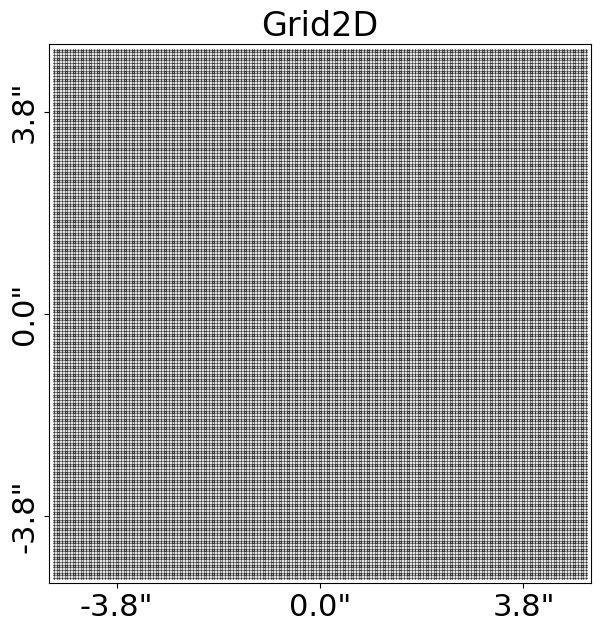

In [30]:
# Cell 3: Create the coordinate grid
# === CONFIGURABLE PARAMETERS ===
GRID_CONFIG = {
    'shape_native': (200, 200),  # Grid dimensions in pixels
    'pixel_scale': 0.05,         # Pixel scale in arcseconds/pixel
}
# ==============================

grid = al.Grid2D.uniform(
    shape_native=GRID_CONFIG['shape_native'],
    pixel_scales=GRID_CONFIG['pixel_scale'],
)

print(f"Grid shape: {grid.shape_native}")
print(f"Pixel scale: {GRID_CONFIG['pixel_scale']} arcsec/pixel")
print(f"Field of view: {GRID_CONFIG['shape_native'][0] * GRID_CONFIG['pixel_scale']:.1f} x {GRID_CONFIG['shape_native'][1] * GRID_CONFIG['pixel_scale']:.1f} arcsec")

# Quick visualization
grid_plotter = aplt.Grid2DPlotter(grid=grid)
grid_plotter.figure_2d()

In [31]:
# Cell 4: Create the main lens galaxy
# === CONFIGURABLE PARAMETERS ===
LENS_GALAXY_CONFIG = {
    'redshift': 0.5,
    'mass_profile': {
        'type': 'Isothermal',
        'einstein_radius': 1.6,
        'centre': (0.0, 0.0),
        'ell_comps': (0.1, 0.0),
    }
}
# ==============================

# Mass profile (isothermal)
lens_mass = al.mp.Isothermal(
    centre=LENS_GALAXY_CONFIG['mass_profile']['centre'],
    einstein_radius=LENS_GALAXY_CONFIG['mass_profile']['einstein_radius'],
    ell_comps=LENS_GALAXY_CONFIG['mass_profile']['ell_comps']
)

# Create the lens galaxy (mass only)
lens_galaxy = al.Galaxy(
    redshift=LENS_GALAXY_CONFIG['redshift'],
    mass=lens_mass
)

print(f"Lens galaxy created at z={LENS_GALAXY_CONFIG['redshift']}")
print(f"Einstein radius: {LENS_GALAXY_CONFIG['mass_profile']['einstein_radius']} arcsec")

# Visualize the lens galaxy
#fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot mass convergence
convergence = lens_mass.convergence_2d_from(grid=grid)
#im1 = axes[0].imshow(convergence, extent=[-5, 5, -5, 5], origin='lower', cmap='plasma')
#axes[0].set_title('Mass Convergence')
#axes[0].set_xlabel('arcsec')
#axes[0].set_ylabel('arcsec')
#plt.colorbar(im1, ax=axes[0])

# Plot gravitational potential
#potential = lens_mass.potential_2d_from(grid=grid)
#im2 = axes[1].imshow(potential, extent=[-5, 5, -5, 5], origin='lower', cmap='coolwarm')
#axes[1].set_title('Gravitational Potential')
#axes[1].set_xlabel('arcsec')
#axes[1].set_ylabel('arcsec')
#plt.colorbar(im2, ax=axes[1])

#plt.tight_layout()
#plt.show()


Lens galaxy created at z=0.5
Einstein radius: 1.6 arcsec


In [32]:
# Cell 5: Create the background source galaxy
# === CONFIGURABLE PARAMETERS ===
# In Cell 5, modify SOURCE_GALAXY_CONFIG to:
SOURCE_GALAXY_CONFIG = {
    'redshift': 1.0,  # Changed from 1.5
    'light_profile': {
        'type': 'Exponential',
        'centre': (0.3, 0.2),
        'ell_comps': (0.1, 0.0),
        'intensity': 0.1,
        'effective_radius': 0.5,
    }
}
# ==============================

source_light = al.lp.Exponential(
    centre=SOURCE_GALAXY_CONFIG['light_profile']['centre'],
    ell_comps=SOURCE_GALAXY_CONFIG['light_profile']['ell_comps'],
    intensity=SOURCE_GALAXY_CONFIG['light_profile']['intensity'],
    effective_radius=SOURCE_GALAXY_CONFIG['light_profile']['effective_radius']
)

source_galaxy = al.Galaxy(
    redshift=SOURCE_GALAXY_CONFIG['redshift'],
    light=source_light
)

print(f"Source galaxy created at z={SOURCE_GALAXY_CONFIG['redshift']}")

Source galaxy created at z=1.0


Tracer created with 2 galaxies
Cosmology: Planck15


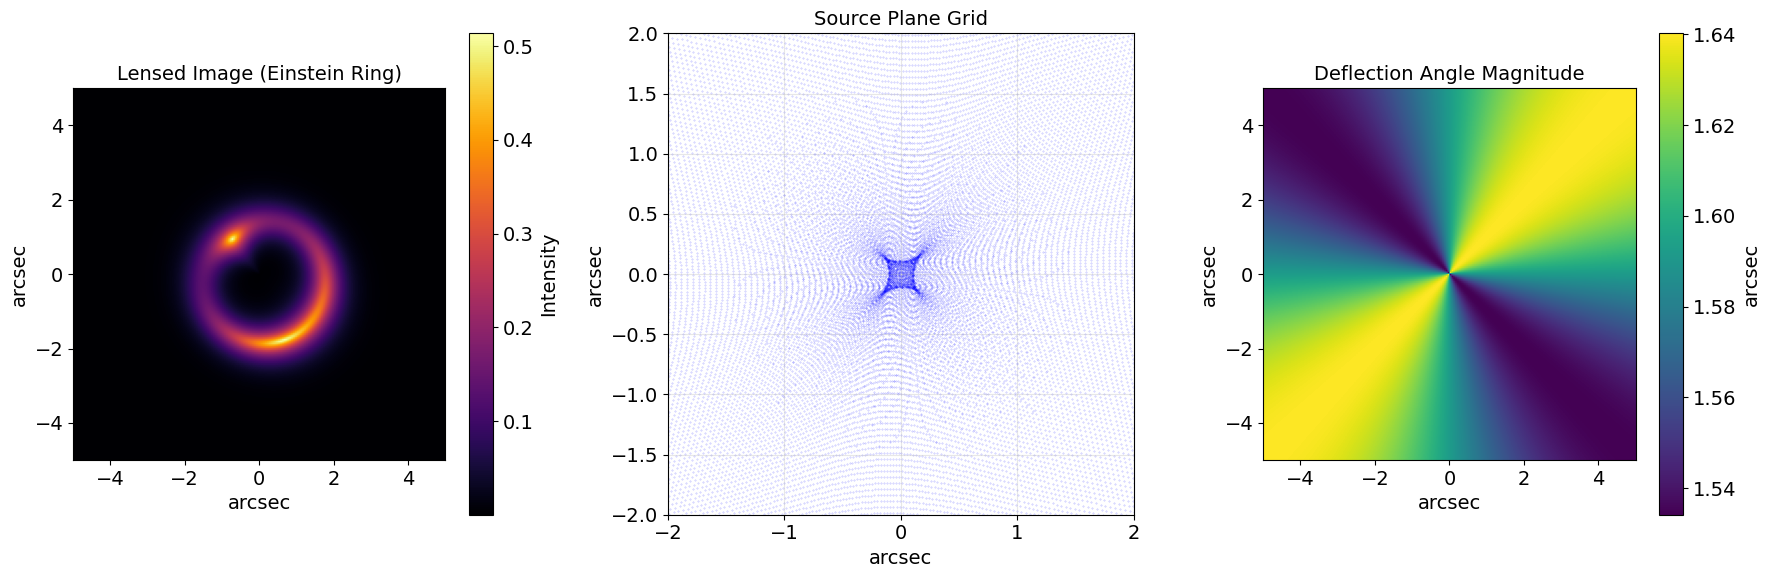

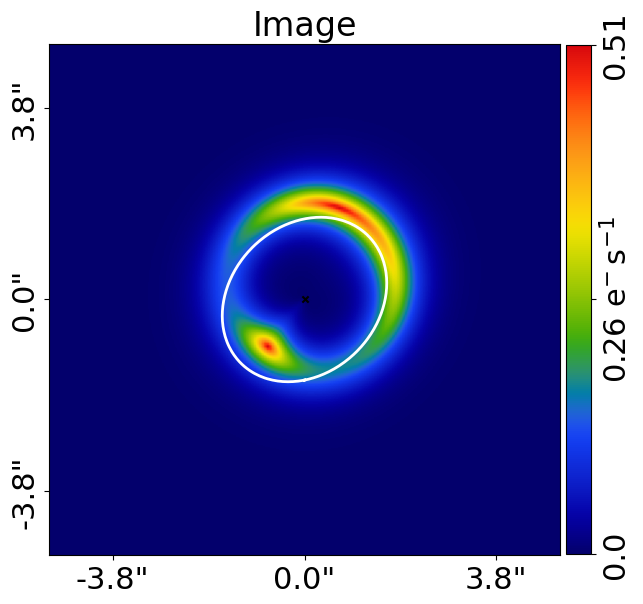

In [33]:
# Cell 6: Create tracer and visualize lensing system
# === CONFIGURABLE PARAMETERS ===
TRACER_CONFIG = {
    'cosmology': 'Planck15',  # Cosmology model to use
}
# ==============================

# Create the tracer with lens and source galaxies
tracer = al.Tracer(
    galaxies=[lens_galaxy, source_galaxy],
    cosmology=al.cosmo.Planck15()
)

print(f"Tracer created with {len(tracer.galaxies)} galaxies")
print(f"Cosmology: {TRACER_CONFIG['cosmology']}")

# Generate the lensed image
lensed_image = tracer.image_2d_from(grid=grid)

# Visualize the lensing system
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot the lensed image (Einstein ring)
im1 = axes[0].imshow(lensed_image.native, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno')
axes[0].set_title('Lensed Image (Einstein Ring)', fontsize=14)
axes[0].set_xlabel('arcsec')
axes[0].set_ylabel('arcsec')
plt.colorbar(im1, ax=axes[0], label='Intensity')

# Plot the source plane
source_plane_grid = tracer.traced_grid_2d_list_from(grid=grid)[1]
axes[1].scatter(source_plane_grid[:, 1], source_plane_grid[:, 0], c='blue', s=0.1, alpha=0.3)
axes[1].set_title('Source Plane Grid', fontsize=14)
axes[1].set_xlabel('arcsec')
axes[1].set_ylabel('arcsec')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
axes[1].grid(True, alpha=0.3)

# Plot deflection angles magnitude
deflections = lens_mass.deflections_yx_2d_from(grid=grid)
deflection_magnitude = np.sqrt(deflections[:, 0]**2 + deflections[:, 1]**2)
im3 = axes[2].imshow(deflection_magnitude.reshape(grid.shape_native), 
                     extent=[-5, 5, -5, 5], origin='lower', cmap='viridis')
axes[2].set_title('Deflection Angle Magnitude', fontsize=14)
axes[2].set_xlabel('arcsec')
axes[2].set_ylabel('arcsec')
plt.colorbar(im3, ax=axes[2], label='arcsec')

plt.tight_layout()
plt.show()

# Use PyAutoLens plotter for a cleaner visualization
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures_2d(image=True)

## Subhalo Functionality

In [ ]:
import numpy as np
from astropy import constants as const
from astropy import units as u


def einstein_radius_point_mass(mass_msun, z_lens=None, z_source=None, cosmology=None):
    """Calculate Einstein radius for a point mass subhalo.
    
    This treats the dark matter subhalo as a point mass, which is standard
    for subhalo detection forecasts. The point mass approximation is valid
    when the subhalo is compact compared to its Einstein radius.
    
    Parameters
    ----------
    mass_msun : `float`
        Mass of the subhalo in solar masses.
    z_lens : `float`
        Redshift of the lens plane where the subhalo resides.
    z_source : `float`
        Redshift of the background source galaxy.
    cosmology : autolens cosmology object, optional
        Cosmology to use. Defaults to PyAutoLens Planck15 if None.
        
    Returns
    -------
    theta_E_arcsec : `float`
        Einstein radius in arcseconds.
        
    Notes
    -----
    For a point mass, the Einstein radius is:
    
    θ_E = sqrt[4GM/c² × D_ls/(D_l × D_s)]
    
    where M is the mass, and D_l, D_s, D_ls are angular diameter distances.
    """
    if cosmology is None:
        import autolens as al
        cosmology = al.cosmo.Planck15()
    
    # Get angular diameter distances
    D_l_obj = cosmology.angular_diameter_distance(z_lens)
    D_s_obj = cosmology.angular_diameter_distance(z_source)
    D_ls_obj = cosmology.angular_diameter_distance_z1z2(z_lens, z_source)
    
    # Extract numerical values in Mpc
    D_l = float(D_l_obj.value) if hasattr(D_l_obj, 'value') else float(D_l_obj)
    D_s = float(D_s_obj.value) if hasattr(D_s_obj, 'value') else float(D_s_obj)
    D_ls = float(D_ls_obj.value) if hasattr(D_ls_obj, 'value') else float(D_ls_obj)
    
    # Convert to meters
    D_l_m = D_l * float((1 * u.Mpc).to(u.m).value)
    D_s_m = D_s * float((1 * u.Mpc).to(u.m).value)
    D_ls_m = D_ls * float((1 * u.Mpc).to(u.m).value)
    
    # Convert mass to kg
    M_kg = mass_msun * float((1 * u.Msun).to(u.kg).value)
    
    # Get constants
    G_SI = float(const.G.value)
    c_SI = float(const.c.value)
    
    # Point mass Einstein radius: θ_E = sqrt[4GM/c² × D_ls/(D_l × D_s)]
    theta_E_rad_squared = (4 * G_SI * M_kg * D_ls_m) / (c_SI**2 * D_l_m * D_s_m)
    theta_E_rad = np.sqrt(theta_E_rad_squared)
    
    # Convert to arcseconds
    theta_E_arcsec = theta_E_rad * float((1 * u.rad).to(u.arcsec).value)
    
    return float(theta_E_arcsec)


def concentration_mass_relation(M200_msun, z=0.5):
    """Calculate NFW concentration parameter from mass.
    
    Uses the concentration-mass relation for subhalos from
    Moline et al. (2017) and similar studies.
    
    Parameters
    ----------
    M200_msun : `float`
        M200 mass in solar masses.
    z : `float`, optional
        Redshift. Default is 0.5.
        
    Returns
    -------
    c200 : `float`
        Concentration parameter (r200/rs).
        
    Notes
    -----
    For subhalos, concentrations are typically ~2x higher than 
    field halos due to tidal stripping of outer regions.
    """
    # Subhalo concentration-mass relation
    # c = c0 * (M/M0)^alpha * (1+z)^beta
    c0 = 19.9  # normalization at z=0
    M0 = 1e8   # pivot mass in Msun
    alpha = -0.195  # mass dependence
    beta = -0.54    # redshift evolution
    
    c200 = c0 * (M200_msun / M0)**alpha * (1 + z)**beta
    
    return float(c200)


def nfw_scale_parameters(M200_msun, c200, z_lens=0.5, cosmology=None):
    """Calculate NFW scale radius and density.
    
    Parameters
    ----------
    M200_msun : `float`
        M200 mass in solar masses.
    c200 : `float`
        Concentration parameter.
    z_lens : `float`, optional
        Lens redshift. Default is 0.5.
    cosmology : autolens cosmology object, optional
        If None, uses PyAutoLens Planck15.
        
    Returns
    -------
    rs_kpc : `float`
        Scale radius in kpc.
    rho_s : `float`
        Scale density in kg/m^3.
    """
    if cosmology is None:
        import autolens as al
        cosmology = al.cosmo.Planck15()
    
    # Get Hubble parameter at z_lens
    H_z_obj = cosmology.H(z_lens)
    H_z = float(H_z_obj.value) if hasattr(H_z_obj, 'value') else float(H_z_obj)
    
    # Critical density at z_lens
    Mpc_to_m = float((1 * u.Mpc).to(u.m).value)
    km_to_m = 1000.0
    H_z_SI = H_z * km_to_m / Mpc_to_m  # 1/s
    G_SI = float(const.G.value)
    rho_crit = 3 * H_z_SI**2 / (8 * np.pi * G_SI)  # kg/m^3
    
    # Calculate r200 from M200
    M200_kg = float((M200_msun * u.Msun).to(u.kg).value)
    r200_m = ((3 * M200_kg) / (4 * np.pi * 200 * rho_crit))**(1/3)
    
    # Scale radius
    rs_m = r200_m / c200
    rs_kpc = float((rs_m * u.m).to(u.kpc).value)
    
    # NFW scale density
    # ρ_s = ρ_crit * (200/3) * c^3 / [ln(1+c) - c/(1+c)]
    f_c = np.log(1 + c200) - c200 / (1 + c200)
    rho_s = rho_crit * (200.0 / 3.0) * c200**3 / f_c
    
    return rs_kpc, rho_s


def einstein_radius_nfw(M200_msun, z_lens=None, z_source=None, cosmology=None, c200=None):
    """Calculate Einstein radius for an NFW dark matter subhalo.
    
    This method uses the Navarro-Frenk-White profile, which is more
    realistic than point mass or SIS for dark matter halos.
    
    Parameters
    ----------
    M200_msun : `float`
        M200 mass of the subhalo in solar masses.
    z_lens : `float`
        Redshift of the lens plane where the subhalo resides.
    z_source : `float`
        Redshift of the background source galaxy.
    cosmology : autolens cosmology object, optional
        Cosmology to use. Defaults to PyAutoLens Planck15 if None.
    c200 : `float`, optional
        Concentration parameter. If None, uses concentration-mass relation.
        
    Returns
    -------
    einstein_radius : `float`
        Einstein radius in arcseconds.
        
    Notes
    -----
    The NFW profile has density ρ(r) = ρ_s / [(r/r_s)(1 + r/r_s)²].
    
    The Einstein radius is found where the mean surface density within
    a circle equals the critical surface density for lensing:
    Σ_crit = c²/(4πG) × D_s/(D_l × D_ls)
    
    This uses an analytical approximation from Wright & Brainerd (2000)
    for the NFW lensing properties.
    """
    if cosmology is None:
        import autolens as al
        cosmology = al.cosmo.Planck15()
    
    # Get concentration if not provided
    if c200 is None:
        c200 = concentration_mass_relation(M200_msun, z_lens)
    
    # Get NFW parameters
    rs_kpc, rho_s = nfw_scale_parameters(M200_msun, c200, z_lens, cosmology)
    
    # Get angular diameter distances
    D_l_obj = cosmology.angular_diameter_distance(z_lens)
    D_s_obj = cosmology.angular_diameter_distance(z_source) 
    D_ls_obj = cosmology.angular_diameter_distance_z1z2(z_lens, z_source)
    
    # Extract values in Mpc
    D_l = float(D_l_obj.value) if hasattr(D_l_obj, 'value') else float(D_l_obj)
    D_s = float(D_s_obj.value) if hasattr(D_s_obj, 'value') else float(D_s_obj)
    D_ls = float(D_ls_obj.value) if hasattr(D_ls_obj, 'value') else float(D_ls_obj)
    
    # Critical surface density for lensing
    c_SI = float(const.c.value)
    G_SI = float(const.G.value)
    
    # Convert distances to meters
    D_l_m = D_l * float((1 * u.Mpc).to(u.m).value)
    D_s_m = D_s * float((1 * u.Mpc).to(u.m).value)
    D_ls_m = D_ls * float((1 * u.Mpc).to(u.m).value)
    
    Sigma_crit = (c_SI**2 / (4 * np.pi * G_SI)) * (D_s_m / (D_l_m * D_ls_m))  # kg/m^2
    
    # Convert scale radius to meters
    rs_m = rs_kpc * float((1 * u.kpc).to(u.m).value)
    
    # NFW characteristic surface density
    # Σ_s = ρ_s × r_s
    Sigma_s = rho_s * rs_m  # kg/m^2
    
    # Dimensionless surface density
    kappa_s = Sigma_s / Sigma_crit
    
    # For NFW, the Einstein radius can be found numerically, but there's
    # an approximate relation for the Einstein radius where κ̄(θ_E) = 1
    # 
    # For typical NFW halos, θ_E ≈ 4 * kappa_s * (r_s/D_l) * f(c)
    # where f(c) is a function of concentration
    
    # Angular scale radius
    theta_s_rad = rs_m / D_l_m  # radians
    
    # For subhalos with c > 10, a good approximation is:
    # θ_E ≈ 4.5 * kappa_s^0.8 * theta_s
    # This captures the transition between point-mass-like (high c)
    # and extended (low c) behavior
    
    if c200 > 10:
        theta_E_rad = 4.5 * kappa_s**0.8 * theta_s_rad
    else:
        # For lower concentrations, use a different approximation
        # that accounts for the more extended mass distribution
        g_c = 1.0 / (np.log(1 + c200) - c200/(1 + c200))
        theta_E_rad = 4.0 * kappa_s * theta_s_rad * g_c * c200**0.5
    
    # Convert to arcseconds
    theta_E_arcsec = float(theta_E_rad * (1 * u.rad).to(u.arcsec).value)
    
    return float(theta_E_arcsec)


def sigma_v_from_m200_sis(M200_msun, z_lens=0.5, cosmology=None):
    """Calculate velocity dispersion for an SIS truncated at r200.
    
    This assumes the SIS profile extends to r200 where the average 
    density equals 200 times the critical density.
    
    Parameters
    ----------
    M200_msun : `float`
        M200 mass in solar masses (mass within r200).
    z_lens : `float`, optional
        Redshift of the lens/subhalo. Default is 0.5.
    cosmology : autolens cosmology object, optional
        If None, uses PyAutoLens Planck15.
        
    Returns
    -------
    sigma_v : `float`
        Velocity dispersion in km/s.
        
    Notes
    -----
    For an SIS truncated at r200, the velocity dispersion is derived from:
    
    M200 = 2σ_v²r200/G
    
    where r200 is calculated from the virial definition at 200 times the
    critical density at the lens redshift.
    """
    if cosmology is None:
        import autolens as al
        cosmology = al.cosmo.Planck15()
    
    # Get Hubble parameter at z_lens - PyAutoLens returns it in km/s/Mpc
    H_z_obj = cosmology.H(z_lens)  # km/s/Mpc from PyAutoLens
    
    # Extract numerical value
    H_z = float(H_z_obj.value) if hasattr(H_z_obj, 'value') else float(H_z_obj)
    
    # Convert H(z) from km/s/Mpc to SI units (1/s)
    # 1 Mpc = 3.086e22 m, so km/s/Mpc = 1000/(3.086e22) = 3.241e-20 1/s
    Mpc_to_m = 3.0857e22  # meters per Mpc
    km_to_m = 1000.0
    H_z_SI = H_z * km_to_m / Mpc_to_m  # Convert to 1/s
    
    # Critical density at z_lens
    G_SI = float(const.G.value)  # Gravitational constant in SI units
    rho_crit = 3 * H_z_SI**2 / (8 * np.pi * G_SI)  # kg/m^3
    
    # Calculate r200 from M200 definition
    # M200 = (4π/3) × r200³ × 200 × ρ_crit
    M200_kg = float((M200_msun * u.Msun).to(u.kg).value)
    r200_m = ((3 * M200_kg) / (4 * np.pi * 200 * rho_crit))**(1/3)  # meters
    
    # For SIS truncated at r200: M200 = 2σ_v²r200/G
    # Therefore: σ_v = sqrt(G × M200 / (2 × r200))
    sigma_v_squared = G_SI * M200_kg / (2 * r200_m)  # m²/s²
    sigma_v_m_s = np.sqrt(sigma_v_squared)  # m/s
    
    # Convert to km/s
    sigma_v_km_s = sigma_v_m_s / 1000.0
    
    return float(sigma_v_km_s)


def einstein_radius_sis_m200(M200_msun, z_lens=None, z_source=None, cosmology=None):
    """Calculate Einstein radius for an SIS subhalo using M200 mass.
    
    This method converts M200 to velocity dispersion assuming an SIS
    truncated at r200, then uses the velocity dispersion to calculate
    the SIS Einstein radius.
    
    Parameters
    ----------
    M200_msun : `float`
        M200 mass of the subhalo in solar masses.
    z_lens : `float`
        Redshift of the lens plane where the subhalo resides.
    z_source : `float`
        Redshift of the background source galaxy.
    cosmology : autolens cosmology object, optional
        Cosmology to use. Defaults to PyAutoLens Planck15 if None.
        
    Returns
    -------
    einstein_radius : `float`
        Einstein radius in arcseconds.
        
    Notes
    -----
    For a Singular Isothermal Sphere (SIS), the Einstein radius is:
    
    θ_E = 4π(σ_v/c)² × (D_ls/D_s)
    
    where σ_v is derived from M200 using virial equilibrium at r200.
    """
    if cosmology is None:
        import autolens as al
        cosmology = al.cosmo.Planck15()
    
    # Convert M200 to velocity dispersion
    sigma_v_km_s = float(sigma_v_from_m200_sis(M200_msun, z_lens, cosmology))
    sigma_v_m_s = sigma_v_km_s * 1000.0  # Convert to m/s
    
    # Get angular diameter distances from PyAutoLens (in Mpc)
    # Force conversion to float to avoid any unit issues
    D_ls_obj = cosmology.angular_diameter_distance_z1z2(z_lens, z_source)
    D_s_obj = cosmology.angular_diameter_distance(z_source)
    
    # Extract numerical values
    D_ls = float(D_ls_obj.value) if hasattr(D_ls_obj, 'value') else float(D_ls_obj)
    D_s = float(D_s_obj.value) if hasattr(D_s_obj, 'value') else float(D_s_obj)
    
    # Calculate SIS Einstein radius
    # θ_E = 4π(σ_v/c)² × (D_ls/D_s)
    # Note: D_ls/D_s is dimensionless, (σ_v/c)² is dimensionless, so result is in radians
    c_m_s = float(const.c.value)  # Speed of light in m/s
    theta_E_rad = 4.0 * np.pi * (sigma_v_m_s / c_m_s)**2 * (D_ls / D_s)
    
    # Convert radians to arcseconds
    # 1 radian = 206264.8062471 arcseconds
    theta_E_arcsec = float(theta_E_rad) * 206264.8062471
    
    return theta_E_arcsec

In [82]:
# Cell 7: Configure and create subhalo with different mass models

# === SUBHALO PARAMETERS ===
SUBHALO_MASS = 1e7  # M_sun

# Point Mass configuration
SUBHALO_CONFIG_PM = {
    'mass': SUBHALO_MASS,
    'profile': 'PointMass',
    'einstein_radius': None,  # Will be calculated
}

# SIS configuration
SUBHALO_CONFIG_SIS = {
    'mass': SUBHALO_MASS,
    'profile': 'SIS',
    'einstein_radius': None,  # Will be calculated
}

# NFW configuration
SUBHALO_CONFIG_NFW = {
    'mass': SUBHALO_MASS,
    'profile': 'NFW',
    'einstein_radius': None,  # Will be calculated
    'concentration': None,  # Will be calculated
}

# Calculate Einstein radii for each model
SUBHALO_CONFIG_PM['einstein_radius'] = einstein_radius_point_mass(
    mass_msun=SUBHALO_CONFIG_PM['mass'],
    z_lens=LENS_GALAXY_CONFIG['redshift'],
    z_source=SOURCE_GALAXY_CONFIG['redshift'],
    cosmology=al.cosmo.Planck15()
)

SUBHALO_CONFIG_SIS['einstein_radius'] = einstein_radius_sis_m200(
    M200_msun=SUBHALO_CONFIG_SIS['mass'],
    z_lens=LENS_GALAXY_CONFIG['redshift'],
    z_source=SOURCE_GALAXY_CONFIG['redshift'],
    cosmology=al.cosmo.Planck15()
)

# For NFW, also get concentration
SUBHALO_CONFIG_NFW['concentration'] = concentration_mass_relation(
    SUBHALO_CONFIG_NFW['mass'], 
    z=LENS_GALAXY_CONFIG['redshift']
)

SUBHALO_CONFIG_NFW['einstein_radius'] = einstein_radius_nfw(
    M200_msun=SUBHALO_CONFIG_NFW['mass'],
    z_lens=LENS_GALAXY_CONFIG['redshift'],
    z_source=SOURCE_GALAXY_CONFIG['redshift'],
    cosmology=al.cosmo.Planck15(),
    c200=SUBHALO_CONFIG_NFW['concentration']
)

# Print comparison
print(f"Subhalo mass: {SUBHALO_MASS:.1e} M_sun")
print(f"Lens redshift: {LENS_GALAXY_CONFIG['redshift']}")
print(f"Source redshift: {SOURCE_GALAXY_CONFIG['redshift']}")
print("\nEinstein Radii:")
print("-" * 50)
print(f"Point Mass:  {SUBHALO_CONFIG_PM['einstein_radius']:.6f} arcsec = {SUBHALO_CONFIG_PM['einstein_radius']*1000:.3f} mas")
print(f"SIS:         {SUBHALO_CONFIG_SIS['einstein_radius']:.6f} arcsec = {SUBHALO_CONFIG_SIS['einstein_radius']*1000:.3f} mas")
print(f"NFW (c={SUBHALO_CONFIG_NFW['concentration']:.1f}): {SUBHALO_CONFIG_NFW['einstein_radius']:.6f} arcsec = {SUBHALO_CONFIG_NFW['einstein_radius']*1000:.3f} mas")
print("\nRatios relative to Point Mass:")
print(f"SIS/PM:  {SUBHALO_CONFIG_SIS['einstein_radius']/SUBHALO_CONFIG_PM['einstein_radius']:.3f}")
print(f"NFW/PM:  {SUBHALO_CONFIG_NFW['einstein_radius']/SUBHALO_CONFIG_PM['einstein_radius']:.3f}")

# For your simulations, choose the most appropriate model
# For now, let's use NFW as it's most realistic
SUBHALO_CONFIG = SUBHALO_CONFIG_NFW  # or _PM or _SIS depending on your needs

Subhalo mass: 1.0e+07 M_sun
Lens redshift: 0.5
Source redshift: 1.0

Einstein Radii:
--------------------------------------------------
Point Mass:  0.005178 arcsec = 5.178 mas
SIS:         0.000070 arcsec = 0.070 mas
NFW (c=25.0): 0.001574 arcsec = 1.574 mas

Ratios relative to Point Mass:
SIS/PM:  0.014
NFW/PM:  0.304


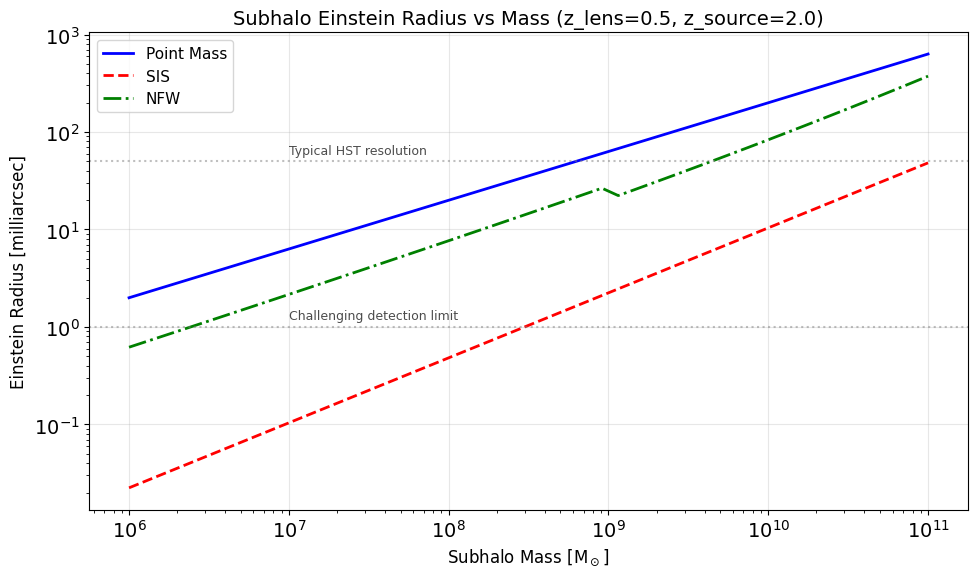

Einstein Radius Comparison (in milliarcsec):
Mass [M_sun]    Point Mass      SIS             NFW             NFW/PM    
------------------------------------------------------------
1e+07           6.308           0.104           2.158           0.342     
1e+08           19.947          0.482           7.670           0.384     
1e+09           63.079          2.239           27.992          0.444     
1e+10           199.473         10.395          83.207          0.417     

NFW Concentration values:
------------------------------
M = 1e+07 M_sun: c200 = 25.0
M = 1e+08 M_sun: c200 = 16.0
M = 1e+09 M_sun: c200 = 10.2
M = 1e+10 M_sun: c200 = 6.5


In [83]:
# Compare different subhalo models across a range of masses

import numpy as np
import matplotlib.pyplot as plt

# Define mass range
masses = np.logspace(6, 11, 50)  # 10^6 to 10^11 M_sun

# Lens and source redshifts (using your values)
z_lens = 0.5  # LENS_GALAXY_CONFIG['redshift']
z_source = 2.0  # SOURCE_GALAXY_CONFIG['redshift']

# Calculate Einstein radii for each model
theta_E_pm = np.array([einstein_radius_point_mass(M, z_lens, z_source) for M in masses])
theta_E_sis = np.array([einstein_radius_sis_m200(M, z_lens, z_source) for M in masses])
theta_E_nfw = np.array([einstein_radius_nfw(M, z_lens, z_source) for M in masses])

# Create comparison plot
plt.figure(figsize=(10, 6))
plt.loglog(masses, theta_E_pm * 1000, 'b-', label='Point Mass', linewidth=2)
plt.loglog(masses, theta_E_sis * 1000, 'r--', label='SIS', linewidth=2)
plt.loglog(masses, theta_E_nfw * 1000, 'g-.', label='NFW', linewidth=2)

plt.xlabel('Subhalo Mass [M$_\\odot$]', fontsize=12)
plt.ylabel('Einstein Radius [milliarcsec]', fontsize=12)
plt.title(f'Subhalo Einstein Radius vs Mass (z_lens={z_lens}, z_source={z_source})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)

# Add reference lines for typical detection limits
plt.axhline(y=50, color='gray', linestyle=':', alpha=0.5, label='_nolegend_')
plt.text(1e7, 60, 'Typical HST resolution', fontsize=9, alpha=0.7)

plt.axhline(y=1, color='gray', linestyle=':', alpha=0.5, label='_nolegend_')
plt.text(1e7, 1.2, 'Challenging detection limit', fontsize=9, alpha=0.7)

plt.tight_layout()
plt.show()

# Print comparison for specific masses
print("Einstein Radius Comparison (in milliarcsec):")
print("="*60)
print(f"{'Mass [M_sun]':<15} {'Point Mass':<15} {'SIS':<15} {'NFW':<15} {'NFW/PM':<10}")
print("-"*60)

test_masses = [1e7, 1e8, 1e9, 1e10]
for M in test_masses:
    theta_pm = einstein_radius_point_mass(M, z_lens, z_source) * 1000
    theta_sis = einstein_radius_sis_m200(M, z_lens, z_source) * 1000
    theta_nfw = einstein_radius_nfw(M, z_lens, z_source) * 1000
    print(f"{M:<15.0e} {theta_pm:<15.3f} {theta_sis:<15.3f} {theta_nfw:<15.3f} {theta_nfw/theta_pm:<10.3f}")

# Also show concentration values
print("\nNFW Concentration values:")
print("-"*30)
for M in test_masses:
    c = concentration_mass_relation(M, z_lens)
    print(f"M = {M:.0e} M_sun: c200 = {c:.1f}")

In [84]:
def get_einstein_ring_position(angle_deg, einstein_radius=None, offset_pixels=0):
    """Get position on or near the Einstein ring."""
    angle_rad = np.deg2rad(angle_deg)
    r = einstein_radius + offset_pixels * GRID_CONFIG['pixel_scale']
    x = r * np.cos(angle_rad)
    y = r * np.sin(angle_rad)
    return (y, x)

# Place subhalo at 45 degrees on Einstein ring
subhalo_position = get_einstein_ring_position(45, einstein_radius=LENS_GALAXY_CONFIG['mass_profile']['einstein_radius'])
print(f"Subhalo position: {subhalo_position}")

Subhalo position: (1.131370849898476, 1.1313708498984762)


In [85]:
# Cell 9: Create lens galaxies with different subhalo profiles

# Dictionary to store different subhalo models
subhalos = {}
lens_galaxies = {}
tracers = {}

# --- Point Mass Subhalo ---
subhalos['PointMass'] = al.mp.PointMass(
    centre=subhalo_position,
    einstein_radius=SUBHALO_CONFIG_PM['einstein_radius']
)

# --- SIS Subhalo ---
# For SIS in PyAutoLens, we need to convert Einstein radius to velocity dispersion
# θ_E = 4π(σ_v/c)² × (D_ls/D_s) => σ_v = c * sqrt(θ_E / (4π × D_ls/D_s))
# But it's easier to use our calculated velocity dispersion directly
sigma_v_sis = sigma_v_from_m200_sis(
    SUBHALO_CONFIG_SIS['mass'], 
    z_lens=LENS_GALAXY_CONFIG['redshift'],
    cosmology=al.cosmo.Planck15()
)

subhalos['SIS'] = al.mp.IsothermalSph(
    centre=subhalo_position,
    einstein_radius=SUBHALO_CONFIG_SIS['einstein_radius']
)

# Create lens galaxies with each subhalo type
for profile_name, subhalo in subhalos.items():
    lens_galaxies[profile_name] = al.Galaxy(
        redshift=LENS_GALAXY_CONFIG['redshift'],
        mass=lens_mass,  # Main lens mass
        subhalo=subhalo  # Subhalo
    )
    
    # Create tracers
    tracers[profile_name] = al.Tracer(
        galaxies=[lens_galaxies[profile_name], source_galaxy],
        cosmology=al.cosmo.Planck15()
    )

# Print summary
print("Created lens galaxies with different subhalo profiles:")
print("=" * 60)
print(f"Subhalo position: {subhalo_position}")
print(f"Subhalo mass: {SUBHALO_MASS:.1e} M_sun")
print("\nEinstein radii:")
print(f"  Point Mass: {SUBHALO_CONFIG_PM['einstein_radius']*1000:.3f} mas")
print(f"  SIS:        {SUBHALO_CONFIG_SIS['einstein_radius']*1000:.3f} mas")

Created lens galaxies with different subhalo profiles:
Subhalo position: (1.131370849898476, 1.1313708498984762)
Subhalo mass: 1.0e+07 M_sun

Einstein radii:
  Point Mass: 5.178 mas
  SIS:        0.070 mas


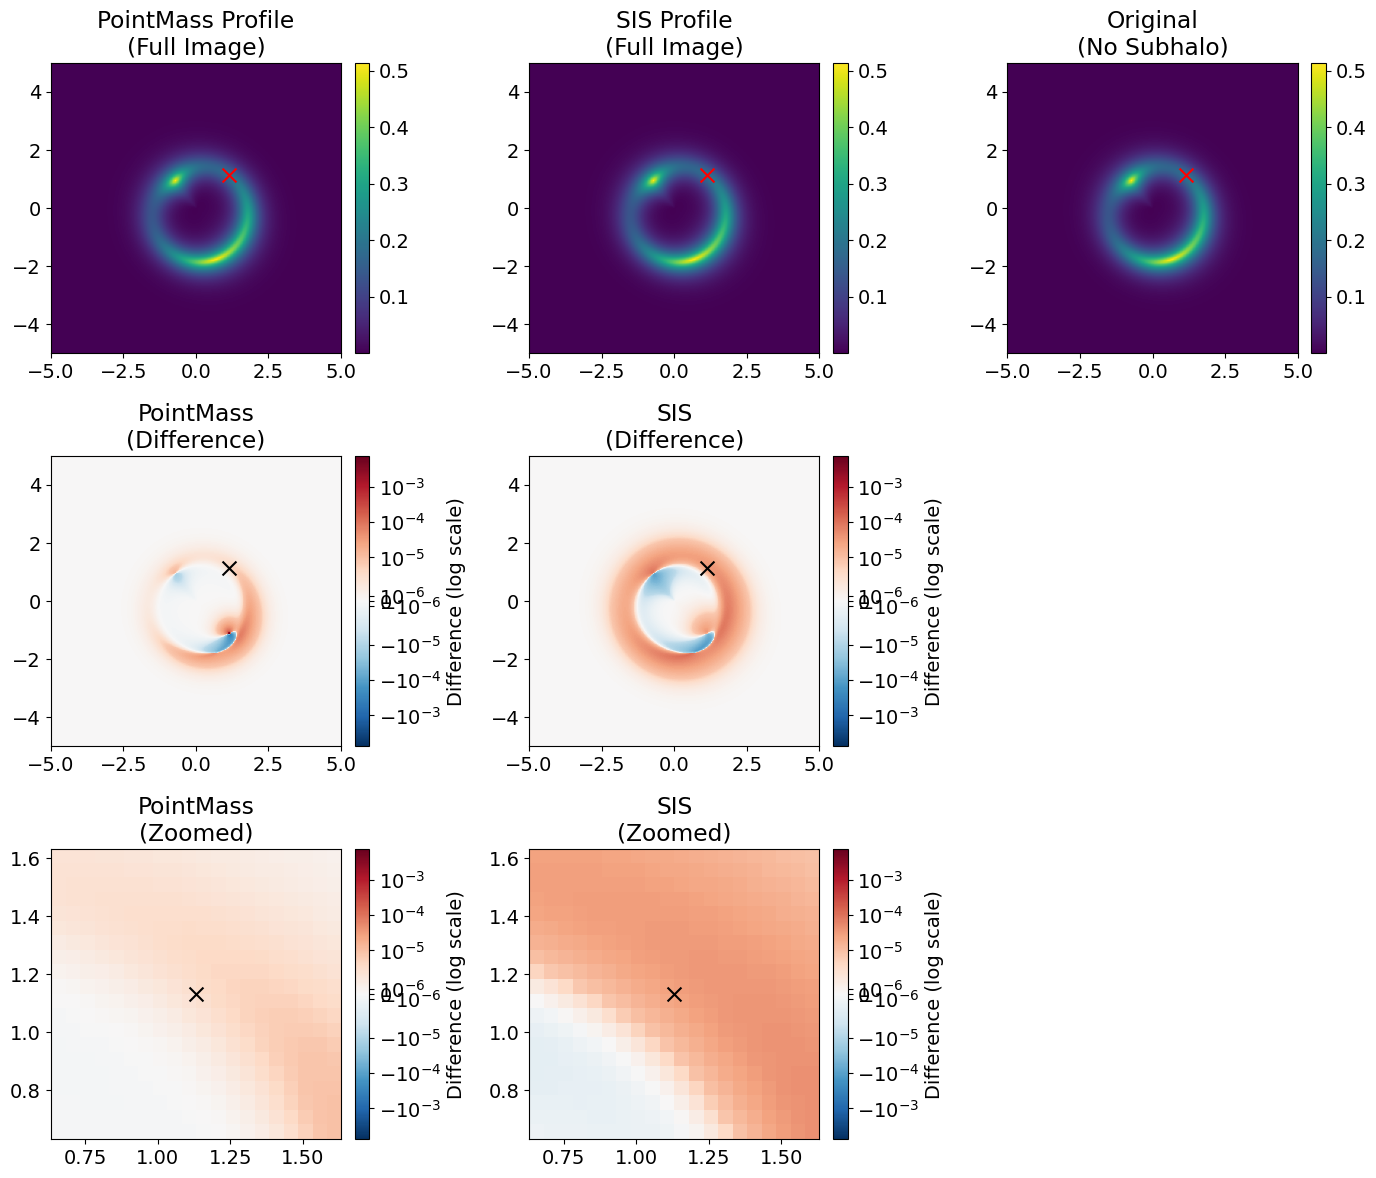


Quantitative Comparison:
Profile      Peak Signal     Total |Signal|       Signal RMS     
----------------------------------------------------------------------
PointMass    0.007508        0.056438             0.000038       
SIS          0.000117        0.151121             0.000011       


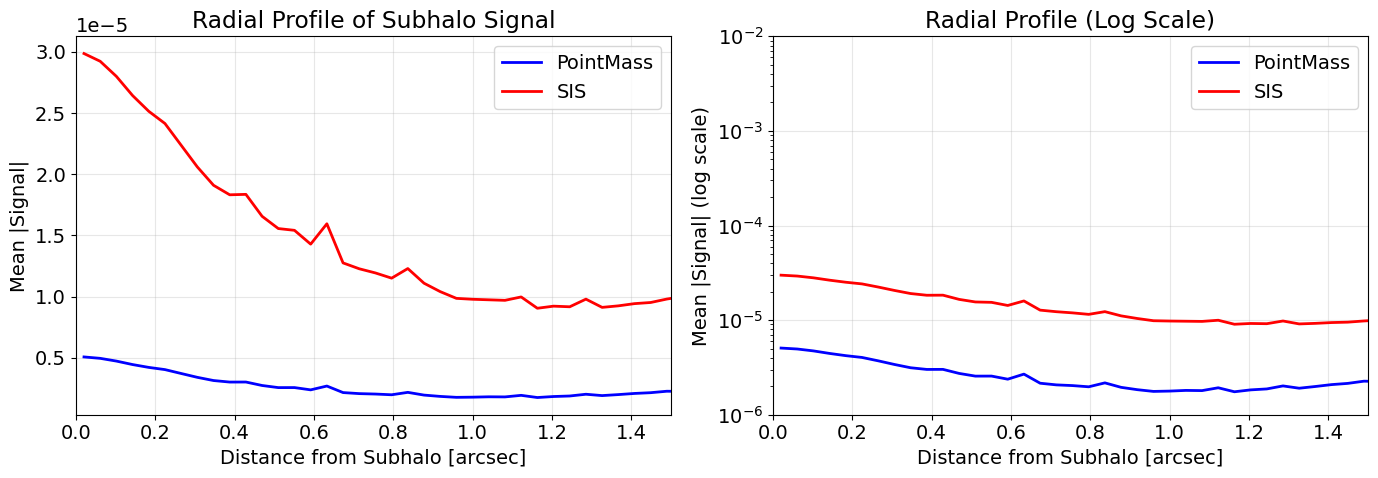

In [87]:
# Cell 10: Compare lensing effects of PointMass and SIS subhalo profiles

from matplotlib.colors import SymLogNorm

# PointMass and SIS
profile_names = ['PointMass', 'SIS']

# Generate images for selected profiles
images = {}
differences = {}

# Original image without subhalo
image_no_subhalo = tracer.image_2d_from(grid=grid)

# Generate images with each subhalo profile
for profile_name in profile_names:
    tracer_with_sub = tracers[profile_name]
    images[profile_name] = tracer_with_sub.image_2d_from(grid=grid)
    differences[profile_name] = images[profile_name] - image_no_subhalo

# Create comparison figure
fig = plt.figure(figsize=(14, 12))

# Top row: Full images
axes_top = []
for i, profile_name in enumerate(profile_names):
    image = images[profile_name]
    ax = plt.subplot(3, 3, i+1)
    axes_top.append(ax)
    im = ax.imshow(image.native, extent=(-5, 5, -5, 5), 
                   origin='lower', cmap='viridis')
    ax.set_title(f'{profile_name} Profile\n(Full Image)')
    ax.scatter(*subhalo_position[::-1], c='red', s=100, marker='x')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Add original for comparison
ax = plt.subplot(3, 3, 3)
im = ax.imshow(image_no_subhalo.native, extent=(-5, 5, -5, 5), 
               origin='lower', cmap='viridis')
ax.set_title('Original\n(No Subhalo)')
ax.scatter(*subhalo_position[::-1], c='red', s=100, marker='x')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

# Middle row: Difference images (log colorbar)
axes_diff = []
max_diff = max([np.max(np.abs(diff)) for diff in differences.values()])
linthresh = max_diff * 1e-3 if max_diff > 0 else 1e-6  # threshold for linear region in log scale
for i, profile_name in enumerate(profile_names):
    diff = differences[profile_name]
    ax = plt.subplot(3, 3, i+4)
    axes_diff.append(ax)
    im = ax.imshow(diff.native, extent=(-5, 5, -5, 5), 
                   origin='lower', cmap='RdBu_r',
                   norm=SymLogNorm(linthresh=linthresh, vmin=-max_diff, vmax=max_diff))
    ax.set_title(f'{profile_name}\n(Difference)')
    ax.scatter(*subhalo_position[::-1], c='black', s=100, marker='x')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Difference (log scale)')

# Bottom row: Zoomed-in views around subhalo (log colorbar)
zoom_size = 0.5  # arcsec
zoom_extent = (subhalo_position[1]-zoom_size, subhalo_position[1]+zoom_size,
               subhalo_position[0]-zoom_size, subhalo_position[0]+zoom_size)

# Find pixel indices for zoom
# grid.extent does not exist; use grid's range and shape
# Assume grid covers from -5 to 5 arcsec in both axes
arcsec_min, arcsec_max = -5, 5
pixels_per_arcsec = grid.shape_native[0] / (arcsec_max - arcsec_min)
center_pixel = grid.shape_native[0] // 2

sub_pixel_x = int(center_pixel + subhalo_position[1] * pixels_per_arcsec)
sub_pixel_y = int(center_pixel + subhalo_position[0] * pixels_per_arcsec)
zoom_pixels = int(zoom_size * pixels_per_arcsec)

for i, profile_name in enumerate(profile_names):
    diff = differences[profile_name]
    ax = plt.subplot(3, 3, i+7)
    
    # Extract zoomed region
    y_start = max(0, sub_pixel_y - zoom_pixels)
    y_end = min(grid.shape_native[0], sub_pixel_y + zoom_pixels)
    x_start = max(0, sub_pixel_x - zoom_pixels)
    x_end = min(grid.shape_native[1], sub_pixel_x + zoom_pixels)
    
    zoomed_diff = diff.native[y_start:y_end, x_start:x_end]
    
    im = ax.imshow(zoomed_diff, extent=zoom_extent,
                   origin='lower', cmap='RdBu_r',
                   norm=SymLogNorm(linthresh=linthresh, vmin=-max_diff, vmax=max_diff))
    ax.set_title(f'{profile_name}\n(Zoomed)')
    ax.scatter(*subhalo_position[::-1], c='black', s=100, marker='x')
    ax.set_xlim(zoom_extent[0:2])
    ax.set_ylim(zoom_extent[2:4])
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Difference (log scale)')

plt.tight_layout()
plt.show()

# Quantitative comparison
print("\nQuantitative Comparison:")
print("=" * 70)
print(f"{'Profile':<12} {'Peak Signal':<15} {'Total |Signal|':<20} {'Signal RMS':<15}")
print("-" * 70)

for profile_name in profile_names:
    diff = differences[profile_name]
    peak_signal = np.max(np.abs(diff))
    total_signal = np.sum(np.abs(diff))
    signal_rms = np.sqrt(np.mean(diff**2))
    
    config = {'PointMass': SUBHALO_CONFIG_PM, 
              'SIS': SUBHALO_CONFIG_SIS}[profile_name]
    
    print(f"{profile_name:<12} {peak_signal:<15.6f} {total_signal:<20.6f} {signal_rms:<15.6f}")

# Plot radial profiles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Calculate radial distances from subhalo position
y_coords, x_coords = np.meshgrid(
    np.linspace(-5, 5, grid.shape_native[0]),
    np.linspace(-5, 5, grid.shape_native[1])
)
radial_distances = np.sqrt((x_coords - subhalo_position[1])**2 + 
                          (y_coords - subhalo_position[0])**2)

# Bin the differences by radius
radial_bins = np.linspace(0, 2, 50)
colors = {'PointMass': 'blue', 'SIS': 'red'}

for profile_name in profile_names:
    diff = differences[profile_name]
    # Calculate mean absolute signal in radial bins
    radial_profile = []
    for i in range(len(radial_bins)-1):
        mask = (radial_distances >= radial_bins[i]) & (radial_distances < radial_bins[i+1])
        if np.any(mask):
            radial_profile.append(np.mean(np.abs(diff.native[mask])))
        else:
            radial_profile.append(0)
    
    bin_centers = (radial_bins[:-1] + radial_bins[1:]) / 2
    ax1.plot(bin_centers, radial_profile, label=profile_name, 
             color=colors[profile_name], linewidth=2)
    ax2.semilogy(bin_centers, radial_profile, label=profile_name, 
                 color=colors[profile_name], linewidth=2)

ax1.set_xlabel('Distance from Subhalo [arcsec]')
ax1.set_ylabel('Mean |Signal|')
ax1.set_title('Radial Profile of Subhalo Signal')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1.5)

ax2.set_xlabel('Distance from Subhalo [arcsec]')
ax2.set_ylabel('Mean |Signal| (log scale)')
ax2.set_title('Radial Profile (Log Scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1.5)
ax2.set_ylim(1e-6, 1e-2)

plt.tight_layout()
plt.show()